# **Table of Content**

1. <a href="#Introduction">Introduction</a>

2. <a href="#Import-Packages">Import Python Packages</a>

3. <a href="#Data-Gathering-Cleaning">Data Gathering and Cleaning</a><br>
3\.1\. <a href="#Data-Source-A">Data Source A. Music: Spotify API</a>  
3\.2\. <a href="#Data-Source-B,C">Data Source B,C. Artist: Wikipedia and Kaggle</a>  
3\.3\. <a href="#Data-Source-D">Data Source D. Lyrics: AZlyrics </a> <br>
3\.4\. <a href="#Data-Combined">Combine Data Sources A,B,C,D</a>

4. <a href="#Data-Analysis">Data Preprocessing</a>

5. <a href="#Visualisation">Data Analysis & Visualisation</a>

6. <a href="#VConclusion">Conclusion</a>


#**1. Introduction**
<a id="Introduction"></a> 
#### The aim of our research is to investigate potential factors that might affect song popularity. By understanding what makes a song popular, artists and songwriters may better accommodate listener preferences in their production. In addition, listeners who have no idea what songs to listen to may find it easier to make choices when creating their playlists. 

# **2. Import Python Packages**
<a id="Import-Packages"></a>
#### Import all the python packages needed:

Use *!pip install package_name* to install packages not available on your PC

e.g. !pip install spotipy

In [ ]:
import csv
from pprint import pprint as pp
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import re
import country_converter as coco
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import wptools as wp

from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from random import uniform
from bs4 import BeautifulSoup
import time
from statistics import median
import nltk
nltk.download('stopwords')

%matplotlib inline

# **3. Data Gathering and Cleaning** 
<a id="Data-Gathering-Cleaning"></a>
#### We gathered data from four sources and combine it to one csv file for analysis

## Data Source A. Music: Spotify API 
<a id="Data-Source-A"></a>
#### Sourcing Data with Spotify API


Step1: Setup for Spotify API

In [ ]:
client_id = "" # Enter your own client_id
client_secret = "" # Enter your own client_secret

sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id, client_secret))

# a long playlist with random songs is chosen
playlist_id = '5S8SJdl1BDc0ugpkEvFsIL'

Step2: Fetch track informaion for all the tracks in the playlist.

Step2a: Save these information in track_feature.csv

In [ ]:
def songs_in_playlist(playlist_id):
    field_names = ['song', 'track_id', 'release_date', 'song_popularity', 'duration(ms)', 'explicit', 'artist_name',
                   'artist_id']

    # write all the information in track_feature.csv
    with open('track_feature.csv', 'w', encoding='utf-8', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(field_names)

        # sp.playlist() gives playlist information by playlist id
        len_playlist = sp.playlist(playlist_id)['tracks']['total']
        # 100 tracks can be fetched per time
        limit = 100
        tracks = []
        for i in range(0, len_playlist, limit):
            
            # fetch trackinformation in the playlist
            # offset - the index of the first item to return
            playlist = sp.playlist_items(playlist_id, offset=i)['items']

            
            for playlist_info in playlist:
                track_info = playlist_info['track']
                song_name = track_info['name']
                
                # neglect songs without a name
                if song_name == '':
                    continue

                artist_info = track_info['artists']
                
                # neglect collaborated songs
                if len(artist_info) != 1:
                    continue

                for artist in artist_info:
                    artist_name = artist['name']

                # search for the song with highest popularity, as it's not ranked in spotify API
                # spotify takes queries with upto 100 characters
                query = 'artist:{} track:{}'.format(artist_name, song_name)[0:100]
                # take the first 10 entries
                track_info = sp.search(q=query, type='track', limit=10)['tracks']['items']
                # find the teack with highest popularity
                song_popularity = 0

                for info_test in track_info:
                    print(info_test)
                    artist_info = info_test['artists'] 
                    if len(artist_info) != 1:
                        continue

                    if info_test['popularity'] > song_popularity:
                        info = info_test
                        song_popularity = info_test['popularity']

                song_popularity = info['popularity']

                artist_name = artist_info[0]['name']
                artist_id = artist_info[0]['id']

                release_date = info['album']['release_date']
                explicit = info['explicit']
                duration_ms = info['duration_ms']
                song_name = info['name']
                track_id = info['id']

                info_list = [song_name, track_id, release_date, song_popularity, duration_ms, explicit, artist_name,
                             artist_id]
                tracks.append(info_list)
                # pp(info_list)
        # pp(tracks)
        writer.writerows(tracks)
        f.close()

    return tracks

songs_in_playlist(longest_playlist_id)

Step2b: Drop dulplicates. 


There will be duplicates due to our methodology in refetching the same song with the highest popularity.
Since the track_id is unique, we can drop duplicates by simply dropping repetitive entries with the same track_id.

Save the file without duplicates in track_feature_cleaned.csv

In [ ]:
df = pd.read_csv("track_feature.csv").drop_duplicates(subset=['track_id'])
df.to_csv('track_feature_cleaned.csv', index=False)

Step2c: Sometimes different artists have the same name. We remove those entries with artists having the same name but different artist_id's. 

Save the file in track_feature_final.csv

In [ ]:
# sort the entries by artist_name and artist_id, to safe running time
# (same names will be next to each other, no need to go through entire list for each entry)
df = pd.read_csv("track_feature_cleaned.csv").sort_values(by=["artist_name", 'artist_id'], ascending=[True, True])

artist_name = df.iat[0, 6]
artist_id = df.iat[0, 7]
drop_list = []

# put all the clashed names in drop_list
for i in range(1, len(df.index)):
    artist_name_test = df.iat[i, 6]
    artist_id_test = df.iat[i, 7]
    if artist_name_test == artist_name and artist_id_test != artist_id:
        drop_list.append(artist_id)
        drop_list.append(artist_id_test)
    artist_name = artist_name_test
    artist_id = artist_id_test

drop_list = list(set(drop_list))
# print(drop_list)

# drop all the entries with artist_name in the drop_list
for row in df.index:
    if df.loc[row, "artist_id"] in drop_list:
        df.drop(row, inplace=True)

df.to_csv('track_feature_final.csv', index=False)

Step3: Combine spotify track information with spotify artist information.

Step3a: Fetch artist informaion for all the artists in track_feature_final.csv and combine it with this file. 

Save it into track_artist_features.csv.

In [ ]:
df = pd.read_csv("track_feature_final.csv")
follower_no_dic = {}
genres_dic = {}
artist_popularity_dic = {}

artist_id_list = df['artist_id'].tolist()
# some artists have multiple songs in the playlist
# we avoid going through same artist information for multiple times by removing duplicates
artist_id_list = list(set(artist_id_list))

for artist_id in artist_id_list:
    # fetch information of the artist
    artist_info = sp.artist(artist_id)
    
    # the running time could be long, print is to check it's running rather than in sleep mode
    print(artist_info)
    follower_no_dic[artist_id] = artist_info['followers']['total']
    artist_popularity_dic[artist_id] = artist_info['popularity']
    genres_dic[artist_id] = artist_info['genres']

df['artist_follower_no'] = df['artist_id'].map(follower_no_dic)
df['artist_genres'] = df['artist_id'].map(genres_dic)
df['artist_popularity'] = df['artist_id'].map(artist_popularity_dic)

df.to_csv('track_artist_features.csv', index=False)

Step3b: Some artists don't have a genre in spotify API, and it would appear as [], we change it to empty.

Save the file as track_artist_features_final.csv

In [ ]:
df = pd.read_csv("track_artist_features.csv")
for row in df.index:
    if df.loc[row, 'artist_genres'] == '[]':
        df.loc[row, 'artist_genres'] = 'N/A'
df.to_csv('track_artist_features_final.csv', index=False)

Step4: Combine spotify audio feature information with spotify track information and spotify artist information.

Step4a: Fetch audio feature for all the tracks in track_artist_features_final.csv and combine it with this file. 

Save it into track_artist_audio_features.csv

In [ ]:
df = pd.read_csv("track_artist_features_final.csv")

acousticness = {}
danceability = {}
energy = {}
instrumentalness = {}
key = {}
liveness = {}
loudness = {}
mode = {}
speechiness = {}
tempo = {}
time_signature = {}
valence = {}

track_id_list = df['track_id'].tolist()

for track_id in track_id_list:
    # fetch the audio feature information
    track_infos = sp.audio_features(track_id)
    
    # the running time could be long, print is to check it's running rather than in sleep mode
    print(track_infos)
    for track_info in track_infos:
        # allows the function to continue if nothing could be fetched
        if track_info is None:
            acousticness[track_id] = 'N/A'
            danceability[track_id] = 'N/A'
            energy[track_id] = 'N/A'
            instrumentalness[track_id] = 'N/A'
            key[track_id] = 'N/A'
            liveness[track_id] = 'N/A'
            loudness[track_id] = 'N/A'
            mode[track_id] = 'N/A'
            speechiness[track_id] = 'N/A'
            tempo[track_id] = 'N/A'
            time_signature[track_id] = 'N/A'
            valence[track_id] = 'N/A'
            continue
        acousticness[track_id] = track_info['acousticness']
        danceability[track_id] = track_info['danceability']
        energy[track_id] = track_info['energy']
        instrumentalness[track_id] = track_info['instrumentalness']
        key[track_id] = track_info['key']
        liveness[track_id] = track_info['liveness']
        loudness[track_id] = track_info['loudness']
        mode[track_id] = track_info['mode']
        speechiness[track_id] = track_info['speechiness']
        tempo[track_id] = track_info['tempo']
        time_signature[track_id] = track_info['time_signature']
        valence[track_id] = track_info['valence']

# mapping values in dictionaries into the csv file via track_id
df['acousticness'] = df['track_id'].map(acousticness)
df['danceability'] = df['track_id'].map(danceability)
df['energy'] = df['track_id'].map(energy)
df['instrumentalness'] = df['track_id'].map(instrumentalness)
df['key'] = df['track_id'].map(key)
df['liveness'] = df['track_id'].map(liveness)
df['loudness'] = df['track_id'].map(loudness)
df['mode'] = df['track_id'].map(mode)
df['speechiness'] = df['track_id'].map(speechiness)
df['tempo'] = df['track_id'].map(tempo)
df['time_signature'] = df['track_id'].map(time_signature)
df['valence'] = df['track_id'].map(valence)

df.to_csv('track_artist_audio_features.csv', index=False)

Step4b: Some tracks can't be properly analysed. In spotify API, time_signature could only have values larger or equal to 3 (equal to 3 indicates 3/8). This is likely to be caused by white noise music, which are unlikely to have correct measurements for other parameters, hence we remove these values. 

We save this file in track_artist_audio_features_final.csv

In [ ]:
df = pd.read_csv("track_artist_audio_features.csv")
for row in df.index:
    if df.loc[row, 'time_signature'] < 3:
        df.loc[row, 'acousticness'] = ''
        df.loc[row, 'danceability'] = ''
        df.loc[row, 'energy'] = ''
        df.loc[row, 'instrumentalness'] = ''
        df.loc[row, 'key'] = ''
        df.loc[row, 'liveness'] = ''
        df.loc[row, 'loudness'] = ''
        df.loc[row, 'mode'] = ''
        df.loc[row, 'speechiness'] = ''
        df.loc[row, 'tempo'] = ''
        df.loc[row, 'time_signature'] = ''
        df.loc[row, 'valence'] = ''

df.to_csv('track_artist_audio_features_final.csv', index=False)

## Data Source B, C. Artist: Wikipedia and Kaggle 
#### Artist personal details from Wikipedia and Kaggle datase
<a id="Data-Source-B,C"></a>

Step1a: Scrap artist's birthday, birth place from Wikipedia 

In [ ]:
# the above csv file was cleaned to enable the artist name match how it is recorded in Wikipedia
music = pd.read_csv('track_artist_audio_features_final.csv')

# drop duplicate index column
music.drop('Unnamed: 0', axis=1, inplace=True)  

# isolate artist id and name
music = music[['artist_id', 'artist_name']]

# drop duplicate artist
music.drop_duplicates(inplace=True)
music

In [ ]:
# split the data into groups because wiki has a time limit for scraping
# this is the error for time limit: (28, 'Failed to connect to en.wikipedia.org port 443 after 21022 ms: Timed out')
# first group
music_first = music[:800].copy()

# second group
music_second = music[800:1600].copy()  

# third group
music_third = music[1601:2400].copy()

# fourth group
music_fourth = music[2400:].copy()

In [ ]:
# function for scraping singer_details and saving to a df
def scrape_infobox(df_name):
    '''
    This function scrapes the infobox of artists from wikipedia and 
    appends the data as new columns to the dataframe
    '''
    count = 0 
    for index, each_name in zip(df_name.index, df_name['artist_name']):
        count += 1
        print(str(count) + ": " + each_name)
        try:
            page = wp.page(each_name).get_parse()
            keys = ['name', 'members', 'current_members', 'birth_name', 'origin', 'birth_place', 'birth_date']
            if keys[0] in page.data['infobox'].keys():  # artist name
                df_name.loc[index, 'name']= page.data['infobox'][keys[0]]
            else:
                df_name.loc[index, 'name'] = np.nan

            if keys[1] in page.data['infobox'].keys():  # bands members name
                df_name.loc[index, 'members'] = page.data['infobox'][keys[1]]
            elif keys[2] in page.data['infobox'].keys():
                df_name.loc[index, 'members'] = page.data['infobox'][keys[2]]
            else:
                df_name.loc[index, 'members'] = np.nan

            if keys[1] in page.data['infobox'].keys():  # members for bands
                df_name.loc[index, 'band'] = 'True'
            elif keys[2] in page.data['infobox'].keys():
                df_name.loc[index, 'band'] = 'True'
            else:
                df_name.loc[index, 'band'] = 'False'

            if keys[3] in page.data['infobox'].keys():  # artist birth name
                df_name.loc[index, 'birth_name'] = page.data['infobox'][keys[3]]
            else:
                df_name.loc[index, 'birth_name'] = np.nan

            if keys[4] in page.data['infobox'].keys():  # nationality
                df_name.loc[index, 'birth_place'] = page.data['infobox'][keys[4]]
            elif keys[5] in page.data['infobox'].keys():
                df_name.loc[index, 'birth_place'] = page.data['infobox'][keys[5]]
            else:
                df_name.loc[index, 'birth_place'] = np.nan

            if keys[6] in page.data['infobox'].keys():  # age
                df_name.loc[index, 'birth_date'] = page.data['infobox'][keys[6]]
            else:
                df_name.loc[index, 'birth_date'] = np.nan

        except AttributeError as err:
            pass
        except TypeError as err:
            pass
        except LookupError as err1:
            pass
        except ValueError as err2:
            pass   

    return

In [ ]:
# scrape data for artist groups individually 
music_first = scrape_infobox(df_name=music_first)
music_second = scrape_infobox(df_name=music_second)
music_third = scrape_infobox(df_name=music_third)
music_fourth = scrape_infobox(df_name=music_fourth)

In [ ]:
# combine the artist groups vertically into one dataframe
artist_details_combined = pd.concat([music_first, music_second, music_third, music_fourth])

Actually, the scraping shouldnt be done in the below manner, i.e saving to four different csv. so we wrote a code(above ) that scrapes then combines the df into one before saving to a csv. (If we leave this here we will be shooting ourselves in the leg)

In [ ]:
# #The artist details were saved to 4 different files due to wikipedia's respond time.
# df1 = pd.read_csv('artist1.csv', encoding='utf-8')
# df2 = pd.read_csv('artist2.csv', encoding='utf-8')
# df3 = pd.read_csv('artist3.csv', encoding='utf-8')
# df4 = pd.read_csv('artist4.csv', encoding='utf-8')

# #To vertically combine all the files
# df_artist = pd.concat([df1, df2, df3, df4], axis=0)
#save the artist details to a file.
df_artist.to_csv('artist_details_combined.csv', index=False)

(Step1c): Name clashes on different artists was discovered later, by that time we already started scraping artists' detail from Wikipedia, hence we take the drop_list value from our previous cell and repeat this process with artist_details_combined.csv 

Name the file artist_details_unique_artist_name.csv

In [ ]:
# drop_list from previous cells, the value was printed and stored, so that we can use it without running the code again
drop_list = ['7lf4M8KM02hIiVGHKsAl2o', '6h9telSBnbabV6eyeQtWO7', '0mZsmXegjYM7hNw0QGE5b7', '2uFUBdaVGtyMqckSeCl0Qj', '68abRTdO4meYReMWHvBYb0', '02J7bo06ZZ1XmSGochlWak', '0hDmcvucqFYoojOpHfDiZ0', '4pchWejl1hLpJ8zXvZlqLb', '6GDDxhe281I5aNSgCYphex', '7n2Ycct7Beij7Dj7meI4X0', '7EXJJpgDl7y4szvrpUYj0s', '3a0gvZAydt98HKVbGb0V67', '0hEurMDQu99nJRq8pTxO14', '0ZkhUsUWbgsB356AUiiIWz', '3TOqt5oJwL9BE2NG9MEwDa', '2m1l9MLSslzup4vvokKgvQ', '37SQDDbylULQMBCICskLdA', '536pTabXNhaK7O7VfjOk7P', '5o7lbGxFCLde3JqX2EKzjZ', '0a1pOwbTl7KjPdm9h7DJT5', '2yp6zqk49KOKKrOSSsUb75', '3EAHF3jdnHHdko5DBrhRUP']
df = pd.read_csv('artist_details_combined.csv', encoding='utf-8')
for row in df.index:
    if df.loc[row, "artist_id"] in drop_list:
        df.drop(row, inplace=True)
df.to_csv('artist_details_unique_artist_name.csv', index=False)

Step2: Combine gender dataset from Kaggle with artist details from Wikipedia

In [ ]:
# read the gender data downloaded from Kaggle
gender_df = pd.read_csv('artists_gender.csv', encoding='latin1')

# read the artist details with unique artist name
artist = pd.read_csv('artist_details_unique_artist_name.csv')

In [ ]:
# combine the above datasets on the artist_name column using a left join
artists_detail_with_category = artist.merge(gender_df, how='left', left_on='artist_name', right_on='artist')

# save the above df to csv
artists_detail_with_category.to_csv('artists_detail_with_category.csv', index=False)

Step3: Organising the data

We need to convert birth place information into birth country, and convert birthday into birth year.


Country:

We will be using a python package called country_converter (coco) to extract country information. 

However, some artist's country information were missing on Wikipedia but available in the Kaggle dataset. Also, the information from Wikipedia were not all organised, e.g. for multicultural artists. Wikipedia did not store the information in a consistent manner; for many artists from the US it showed the state but not the country name. 

There is not a python package that could fetch city or state information to convert it into country, so we extracted country information from Kaggle (column 'category') first, and made it overwrite the data from Wikipedia (column 'birth_place'). Then we went through column 'birth_place'.


Birth year:

To simplify the process, we convert birth_date to birth_year at the same time. 




Step3a: 


Convert birth_date to birth_year. 


Overwrite country information extracted from Kaggle to Wikipedia 


Save the process into artist_category_to_more.csv 


In [ ]:
df = pd.read_csv('artists_detail_with_category.csv', encoding='utf-8')
df = df.sort_values(by=['category'], ascending=True)

for row in df.index:
    artist_category = str(df.loc[row, 'category'])
    if artist_category == 'nan':
        # print('break')
        break
    else:
        
        # some of the variations and counties can't be recognized by country_converter
        if 'American' in artist_category:
            df.loc[row, 'birth_place'] = 'United States'
        elif 'Canadian' in artist_category:
            df.loc[row, 'birth_place'] = 'Canada'
        elif any(c in artist_category for c in ('British', 'English', 'Scottish', 'Welsh')):
            df.loc[row, 'birth_place'] = 'United Kingdom'
            print('uk')
        else:
            artist_country = coco.convert(artist_category, to='name_short')
            if artist_country != 'not found':
                df.loc[row, 'birth_place'] = artist_country
                print(artist_country)

#to get only the birth year of the artists
df['birth_year'] = df['birth_date'].str.extract(r'(\d{4})')

df.to_csv('artist_category_to_more.csv', index=False)

Step3b: Extract all the country information and store it in artist_country column 


Save it in artists_details_final.csv

In [ ]:
df = pd.read_csv('artist_category_to_more.csv', encoding='utf-8')
artist_country_dic = {}

birth_place_list = df['birth_place'].tolist()
birth_place_list = list(set(birth_place_list))

for birth_place in birth_place_list:
    artist_country = []
    bp = re.sub('[^A-Za-z ,]+', '', str(birth_place)).split(',')
    for element_raw in bp:
        element = element_raw.strip()
        
        # some of the variations and counties can't be recognized by country_converter  
        if element in ('England', 'Scotland', 'Wales', 'Northern Ireland', 'UK'):
            artist_country.append('United Kingdom')
        elif element == 'U.S.':
            artist_country.append('United State')
        else:
            country = coco.convert(element, to='name_short')
            if country != 'not found':
                if type(country) == list:
                    for c in country:
                        artist_country.append(c)
                else:
                    artist_country.append(country)

    if len(artist_country) > 1:
        artist_country_cleaned = []
        for ac in artist_country:
            if ac not in artist_country_cleaned:
                artist_country_cleaned.append(ac)
                
        # remove error due to (comonents in) city/state name clashes country name
        if 'United States' in artist_country_cleaned:
            if 'Georgia' in artist_country_cleaned:
                artist_country_cleaned.remove('Georgia')
            if 'Jersey' in artist_country_cleaned:
                artist_country_cleaned.remove('Jersey')
        if 'Trinidad and Tobago' in artist_country_cleaned:
            if 'Spain' in artist_country_cleaned:
                artist_country_cleaned.remove('Spain')
        artist_country = artist_country_cleaned

    if len(artist_country) == 1:
        artist_country_dic[birth_place] = artist_country[0]
    elif len(artist_country) == 0:
        artist_country_dic[birth_place] = 'N/A'
    else:
        artist_country_dic[birth_place] = 'multicultural'

df['artist_country'] = df['birth_place'].map(artist_country_dic)

df.to_csv('artists_details_final.csv', index=False)

## Data Source D. Lyrics: Azlyrics
#### Lyrics scraped from azlyrics.com



<a id="Data-Source-D"></a>

In [ ]:
# LIRYCS SELENIUM

CHROMEDRIVER_PATH = '/Users/alisayanovski/Programming/drivers/chromedriver'

options = webdriver.ChromeOptions()
options.add_experimental_option("excludeSwitches", ["enable-automation"])
options.add_experimental_option("useAutomationExtension", False)
service = ChromeService(executable_path=CHROMEDRIVER_PATH)

# get songs list as DataFrame

songs_data = pd.read_csv('track_artist_audio_features_final.csv')

# extract artist name and song name information, save them as tuples to a list

songs_list = []

for i in range(len(songs_data)):
    artist_name = songs_data.loc[i]['artist_name']
    song = songs_data.loc[i]['song']
    songs_list.append([artist_name, song])

# function for scraping each song

START_URL = 'https://www.azlyrics.com'
QUERY_SELECTOR = '#q'
SONG_LINK_SELECTOR = '.panel table > tbody:first-child a'
LYRICS_SELECTOR = '.col-xs-12.col-lg-8.text-center div:nth-of-type(5)'

def get_lyrics(artist_name, song):
    '''
    Takes as parameters two strings: artist_name and song.
    Returnes text of the lyrics for this artist 
    '''
    query = f'{artist_name.casefold()} {song.casefold()}'

    try:
        # go to the webpage
        driver.get(START_URL)
        
        # wait random time to imitate user behaviour
        time.sleep(uniform(2, 5))

        # write and send a query in a search field
        input_el = WebDriverWait(driver, 10).until(
                   EC.presence_of_element_located((By.CSS_SELECTOR, QUERY_SELECTOR)))
        input_el.send_keys(query + Keys.ENTER)

        # wait
        time.sleep(uniform(2, 5))
        
        # get first element of the search result and click the link
        song_link = WebDriverWait(driver, 10).until(
                   EC.presence_of_element_located((By.CSS_SELECTOR, SONG_LINK_SELECTOR)))

        song_link.click()
        
        # wait
        time.sleep(uniform(7, 12))

        # get the page with lyrics and save the text
        soup = BeautifulSoup(driver.page_source)        
        text = soup.select(LYRICS_SELECTOR)[0].text

        return text
    
    except:
        return ''

# initiate webdriver
driver = webdriver.Chrome(service=service, options=options)

# get the lyrics from the website and put into a list
lyrics = []

for artist_name, song in songs_list:
    text = get_lyrics(artist_name, song)
    lyrics.append((artist_name, song, text))

# quit the driver    
driver.quit()

#create dataframe, clean empty values and save to a file

df_lyrics = pd.DataFrame(lyrics, columns=['artist_name', 'song', 'lyrics'])
cleaned_lyrics = df_lyrics[df_lyrics['lyrics'] != '']
cleaned_lyrics.to_csv('lyrics_selenium.csv', index=False)

# merge lyrics with the rest of information

ids_part = songs_data[['artist_name', 'artist_id', 'song', 'track_id']]
ids_part_merged = pd.merge(cleaned_lyrics, ids_part, on=['artist_name', 'song'], how='left')
no_duplicates_df = ids_part_merged.dropna().drop_duplicates(subset=['artist_name', 'song'])

no_duplicates_df.to_csv('lyrics_scrapping.csv', index=False)

In [ ]:
# ADD METRICS FOR LYRICS

# words to exclude
STOPWORDS_ENG = stopwords.words('english')

# helper functions
def clean_text(text):
    '''
    Takes text (str) as parameter. 
    Returns list of words from text without capital letters and punctuation.
    '''
    return list(filter(None, re.sub(r'[^\w\\s]', ' ', text.lower()).split(' ')))

def remove_stopwords(words_list, stopwords_list):
    '''
    Takes list of words and list of stopwords as parameters.
    Returns list of words cleaned of stopwords.
    '''
    unique_words = set(words_list)
    return [word for word in unique_words if word not in stopwords_list]

def get_unique_words_list(text, stopwords_list):
    '''
    Takes text (str) and list of stopwords as parameters. 
    Returns list of words with no repetitions.
    '''
    words_list = clean_text(text)
    unique_words = set(words_list)
    unique_words_no_stopwords = remove_stopwords(words_list, stopwords_list)
    
    return unique_words_no_stopwords

# main functions

def count_unique_words_rate(text, stopwords_list):
    '''
    Takes text (str) and list of stopwords as parameters.
    Returns ratio of unique words in text (float).
    '''
    total_words = clean_text(text)
    unique_words_no_stopwords = get_unique_words_list(' '.join(total_words), stopwords_list)
    
    return round(len(unique_words_no_stopwords) / len(total_words), 2)


def count_total_char(text):
    '''
    Takes text (str) as parameter. 
    Returns total number of characters without punctuation.
    '''
    return len(re.sub(r'[^\w\\s]', '', text))


def get_repetitions_rate(text, stopwords_list):
    '''
    Takes text (str) and list of stopwords as parameters. 
    Returns mean average number of repetitions of word, if it appears more than once (float).
    '''
    unique_words = get_unique_words_list(text, stopwords_list)

    dict_words = {}

    for word in text:
        if word:
            if word in dict_words:
                dict_words[word] += 1

            else:
                dict_words[word] = 1

    repeating_words = []  

    for key, value in dict_words.items():
        if value > 1:
            repeating_words.append(value)
    
    if repeating_words:
        return round(sum(repeating_words) / len(repeating_words), 2)
    else: 
        return 0


def get_repetitions_rate_median(text, stopwords_list):
    '''
    Takes text (str) and list of stopwords as parameters. 
    Returns median average number of repetitions of word, if it appears more than once (float).
    '''
    unique_words = get_unique_words_list(text, stopwords_list)

    dict_words = {}

    for word in text:
        if word:
            if word in dict_words:
                dict_words[word] += 1

            else:
                dict_words[word] = 1

    repeating_words = []  

    for key, value in dict_words.items():
        if value > 1:
            repeating_words.append(value)
    
    if repeating_words:
        return median(repeating_words)
    else: 
        return 0
    
def count_total_words(text):
    '''
    Takes text (str) as parameter. 
    Returns number of words (int).
    '''
    return len(clean_text(text))


def get_mean_word_len(text, stopwords_list):
    '''
    Takes text (str) and list of stopwords as parameters.  
    Returns average number of characters per word (float).
    '''
    words_list = clean_text(text)
    total_words_no_stopwords = remove_stopwords(words_list, stopwords_list)

    return round(len(''.join(total_words_no_stopwords)) / len(get_unique_words_list(text, stopwords_list)), 2)


def get_mean_sentence_len(text):
    '''
    Takes text (str) as parameter.  
    Returns average number of words per line (float).
    '''
    sentence_list = list(filter(None, text.split('\n')))
    line_len_list = [len(el) for el in sentence_list]
    return round(sum(line_len_list) / len(sentence_list), 2)

def count_word(word, text):
    '''
    Takes text (str) and a word as parameters.  
    Returns number of word appearance in the text.
    '''
    words_list = clean_text(text)
    return words_list.count(word)

def get_metrics(text):
    '''
    Takes text (str) as parameter. 
    Returns tuple of metrics for this text.
    '''
    STOPWORDS_LIST = stopwords.words('english')
    
    repetitions_rate = get_repetitions_rate(text, STOPWORDS_LIST)
    mean_sentence_len = get_mean_sentence_len(text)
    mean_word_len = get_mean_word_len(text, STOPWORDS_LIST)
    unique_words_rate = count_unique_words_rate(text, STOPWORDS_LIST)
    total_words = count_total_words(text)
    total_char = count_total_char(text)

    # new functions
    repetitions_rate_median = get_repetitions_rate_median(text, STOPWORDS_LIST)
    
    # count words
    words_counts = []
    for word in top_repeaded_words_no_stopwords: ###
        words_counts.append(count_word(word, text))
        
        
    return (total_char, total_words, mean_word_len, mean_sentence_len, unique_words_rate, repetitions_rate,
           repetitions_rate_median, *words_counts)


def write_row_to_csv(df, values_tuple):
    '''
    Takes df and metrics tuple as parameters. 
    Writes values to a df. Df should already exist!
    '''
    for i in range(len(values_tuple)):
        df['total_char'][i] = values_tuple[i][0]
        df['total_words'][i] = values_tuple[i][1]
        df['mean_word_len'][i] = values_tuple[i][2]
        df['mean_sentence_len'][i] = values_tuple[i][3]
        df['unique_words_rate'][i] =values_tuple[i][4]
        df['repetitions_rate'][i] = values_tuple[i][5]
        
        #new
        df['repetitions_rate_median'][i] = values_tuple[i][6]
        
        # count words
        j = 0
        for word in top_repeaded_words_no_stopwords: ###
            j += 1
            df[f'count_word_{word}'][i] = values_tuple[i][6 + j]

def count_top_repeating_words(text, words_num):
    '''
    Takes text (str) and number (int) of top words to be returned as parameters. 
    Returns list of top repeating words of given length.
    '''
    cleaned_text = clean_text(text.replace('\\n', ' ').replace('\\', ' '))
    
    dict_all_words = {}

    for word in cleaned_text:
        if word:
            if word in dict_all_words:
                dict_all_words[word] += 1

            else:
                dict_all_words[word] = 1
                
    sorted_words = [k for k, v in sorted(dict_all_words.items(), key=lambda item: item[1], reverse=True)]
    
    return sorted_words[:words_num]

# get top repeated words 
top_repeaded_words_no_stopwords = [word for word in top_repeated_words if word not in STOPWORDS_ENG]

lyrics_raw = df_lyrics['lyrics'].to_string(index=False)
cleaned_lyrics_list = clean_text(lyrics_raw)
lyrics_no_stopwords = [word for word in cleaned_lyrics_list if word not in STOPWORDS_ENG]
clean_lyrics_string = ' '.join(lyrics_no_stopwords)

top_repeaded_words_no_stopwords = count_top_repeating_words(clean_lyrics_string, 20)

# write metrics to a file
df_lyrics = pd.read_csv('lyrics_scrapping.csv')

additional_columns = [f'count_word_{word}' for word in top_repeaded_words_no_stopwords]

df_metrics = pd.DataFrame(df_lyrics, columns=['repetitions_rate',
                                            'mean_sentence_len',
                                            'mean_word_len',
                                            'unique_words_rate',
                                            'total_words',
                                            'total_char',
                                            'repetitions_rate_median',
                                             *additional_columns])

lyrics = df_lyrics['lyrics']
write_row_to_csv(df_metrics, lyrics.apply(get_metrics))

df_final = pd.concat([df_lyrics, df_metrics], axis="columns")
df_final.to_csv('lyrics_final.csv', index=False)

## **Combine Data Sources A,B,C,D**
<a id="Data-Combined"></a>

#### Data for music, artist and lyrics are combined for further analysis

In [ ]:
# combine artist_detail file with spotify_api file
df_spotify = pd.read_csv('track_artist_audio_features_final.csv', encoding='utf-8')

df_artist = pd.read_csv('artists_details_final.csv', encoding='utf-8')
df_artist = df_artist.rename(columns={'spotify track artist audio.artist_id': 'artist_id'}).dropna(subset=['artist_id'])
df_artist = df_artist[['artist_id', 'birth_year', 'artist_country', 'gender', 'band']]

combined = pd.merge(df_spotify, df_artist, how='left', on='artist_id')

combined.to_csv('combined_spotify_w_artist_details.csv', index=False)


In [ ]:
# combine all the file
df_spotify_w_artist = pd.read_csv('combined_spotify_w_artist_details.csv', encoding='utf-8')

df_lyrics = pd.read_csv('lyrics_final.csv', encoding='utf-8')
df_lyrics = df_lyrics.drop(columns=['song', 'artist_name', 'artist_id', 'lyrics', 'repetitions_rate_median'])

combined = pd.merge(df_spotify_w_artist, df_lyrics, how='left', on='track_id')
combined.to_csv('combined_final.csv', index=False)


# **4. Data Preprocessing**
<a id="Data Preprocessing"></a>

#### Analysis of combined data for music, artist and song lyrics



Step1: Know more about our data

In [ ]:
pd.set_option('display.max_columns', 100)
df = pd.read_csv('combined_final.csv', encoding='utf-8')
df.describe(include='all')

,song,track_id,release_date,song_popularity,duration(ms),explicit,artist_name,artist_id,artist_follower_no,artist_genres,artist_popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,birth_year,artist_country,gender,band,repetitions_rate,mean_sentence_len,mean_word_len,unique_words_rate,total_words,total_char,count_word_i,count_word_you,count_word_oh,count_word_know,count_word_it,count_word_like,count_word_got,count_word_and,count_word_yeah,count_word_we,count_word_one,count_word_love,count_word_the,count_word_go,count_word_time,count_word_get,count_word_me,count_word_when,count_word_come,count_word_all
count,7201,7201,7201,7201.000000,7.201000e+03,7201,7201,7201,7.201000e+03,6623,7201.000000,7153.000000,7153.000000,7153.000000,7153.000000,7153.000000,7153.000000,7153.000000,7153.000000,7153.000000,7153.000000,7153.000000,7153.000000,2416.000000,5135,1759,5464,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000
unique,6785,7201,2476,NaN,NaN,2,3071,3071,NaN,2173,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Home,4eOycahNij77maJicwgHvy,2013-01-01,NaN,NaN,False,Taylor Swift,06HL4z0CvFAxyc27GXpf02,NaN,['pop'],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,male,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,7,1,102,NaN,NaN,6682,103,103,NaN,132,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3041,1083,3103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,51.909874,2.836999e+05,NaN,NaN,NaN,5.315898e+06,NaN,57.343147,0.237389,0.556860,0.653853,0.099938,5.253600,0.186045,-7.661730,0.664756,0.064116,121.141731,3.950370,0.471709,1973.685844,NaN,NaN,NaN,38.505920,31.739457,5.063576,0.221031,311.104022,1115.302589,15.612344,12.412159,2.301433,1.889736,5.855756,1.980120,1.172908,6.188858,1.408692,3.058715,0.993528,1.868932,10.042996,1.139390,0.965326,1.130143,5.037448,1.439667,0.855294,2.283634
std,NaN,NaN,NaN,18.108126,4.465146e+05,NaN,NaN,NaN,1.217781e+07,NaN,21.192055,0.291704,0.160001,0.226139,0.243613,3.572906,0.155160,4.220787,0.472109,0.067928,28.276143,0.259436,0.247863,23.910258,NaN,NaN,NaN,13.995913,11.155487,0.383404,0.085498,160.170650,583.789186,14.423815,12.278089,7.757792,4.230099,7.907178,6.704641,2.896945,6.248694,5.188592,5.902308,2.597100,5.670952,9.148309,2.983304,2.470861,3.261466,7.197976,2.594247,2.908763,3.603434
min,NaN,NaN,NaN,1.000000,5.191900e+04,NaN,NaN,NaN,0.000000e+00,NaN,0.000000,0.000001,0.058500,0.000020,0.000000,0.000000,0.015700,-44.907000,0.000000,0.022700,43.509000,3.000000,0.000010,1734.000000,NaN,NaN,NaN,2.400000,10.500000,3.000000,0.010000,5.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,41.000000,1.979730e+05,NaN,NaN,NaN,1.249330e+05,NaN,48.000000,0.012600,0.457000,0.505000,0.000000,2.000000,0.094800,-9.237000,0.000000,0.033200,99.995000,4.000000,0.273000,1964.000000,NaN,NaN,NaN,28.970000,26.192500,4.830000,0.160000,210.000000,758.000000,5.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,NaN,NaN,NaN,54.000000,2.258530e+05,NaN,NaN,NaN,9.554630e+05,NaN,62.000000,0.094200,0.565000,0.696000,0.000053,5.000000,0.122000,-6.557000,1.000000,0.042200,119.979000,4.000000,0.462000,1981.000000,NaN,NaN

Step2: Modify values in each column to the same form to give consistency

Step2a: Change release_date accuracy to 3 significant figures (e.g. 1980s)

In [ ]:
for row in df.index:
    release_date = df.loc[row, 'release_date']
    if str(release_date) != 'nan':
        df.loc[row, 'release_year'] = release_date[:3]+'0s'
        
# df.describe(include='all')

(Step2b): Change artist_genres into bigger categories. This could be done while working on spotify API.

In [ ]:
df = df.sort_values(by='artist_genres')

for row in df.index:
    genres = df.loc[row, 'artist_genres']
    if str(genres) == 'nan':
        break
    else:
        if str(genres).find('worship') != -1 or str(genres).find('christian') != -1 or str(genres).find('ccm') != -1:
            df.loc[row, 'artist_genres'] = 'christian'
        elif str(genres).find('electro') != -1 or str(genres).find('8-bit') != -1 or str(genres).find('digit') != -1 or str(genres).find('chill') != -1 or str(genres).find('wave') != -1 or str(genres).find('ambient') != -1 or str(genres).find('core') != -1:
            df.loc[row, 'artist_genres'] = 'electronic'
        elif str(genres).find('dance') != -1 or str(genres).find('disco') != -1 or str(genres).find('house') != -1 or str(genres).find('edm') != -1:
            df.loc[row, 'artist_genres'] = 'electronic'  
        elif str(genres).find('metal') != -1 or str(genres).find('rock') != -1 or str(genres).find('psych') != -1 or str(genres).find('punk') != -1:
            df.loc[row, 'artist_genres'] = 'metal / rock'
        elif str(genres).find('hip') != -1 or str(genres).find('rap') != -1:
            df.loc[row, 'artist_genres'] = 'hip hop / rap'    
        elif str(genres).find('environment') != -1 or str(genres).find('sleep') != -1 or str(genres).find('water') != -1 or str(genres).find('zen') != -1:
            df.loc[row, 'artist_genres'] = 'sleep / environmental'     
        elif str(genres).find('cappella') != -1:
            df.loc[row, 'artist_genres'] = 'acappella'   
        elif str(genres).find('country') != -1 or str(genres).find('folk') != -1:
            df.loc[row, 'artist_genres'] = 'country / folk'
        elif str(genres).find('pop') != -1:
            df.loc[row, 'artist_genres'] = 'pop'
        elif str(genres).find('soul') != -1 or str(genres).find('r&b') != -1 or str(genres).find('blue') != -1 or str(genres).find('jazz') != -1:
            df.loc[row, 'artist_genres'] = 'r&b / soul / jazz'
        elif str(genres).find('orchestra') != -1 or str(genres).find('\'classical\'') != -1:
            df.loc[row, 'artist_genres'] = 'orchestra / classical'    
        elif str(genres).find('band') != -1 or str(genres).find('core') != -1:
            df.loc[row, 'artist_genres'] = 'band' 
        elif str(genres).find('vgm') != -1 or str(genres).find('soundtrack') != -1 or str(genres).find('disney') != -1 or str(genres).find('hollywood') != -1:
            df.loc[row, 'artist_genres'] = 'soundtrack'  
        elif str(genres).find('easy') != -1 or str(genres).find('lounge') != -1:
            df.loc[row, 'artist_genres'] = 'lounge' 
        elif str(genres).find('karaoke') != -1:
            df.loc[row, 'artist_genres'] = 'karaoke' 
        else: 
            df.loc[row, 'artist_genres'] = 'N/A'

df = df.sort_values(by='artist_genres', ascending=True)
                    
# df.describe(include='all')

(Step2c): Remove audio feature for sleep / environmental music. This could be done while working on spotify API.

In [ ]:
for row in df.index:
    if df.loc[row, 'artist_genres'] == 'sleep / environmental':
        df.loc[row, 'acousticness'] = ''
        df.loc[row, 'danceability'] = ''
        df.loc[row, 'energy'] = ''
        df.loc[row, 'instrumentalness'] = ''
        df.loc[row, 'key'] = ''
        df.loc[row, 'liveness'] = ''
        df.loc[row, 'loudness'] = ''
        df.loc[row, 'mode'] = ''
        df.loc[row, 'speechiness'] = ''
        df.loc[row, 'tempo'] = ''
        df.loc[row, 'time_signature'] = ''
        df.loc[row, 'valence'] = ''

# df.describe(include='all')

(Step2d): Remove birth year for bands

In [ ]:
for row in df.index: 
    if df.loc[row, 'band'] == True:
        df.loc[row, 'birth_year'] = 'nan'

# df.describe(include='all')

Step2e: Change release_date accuracy to 3 significant figures (e.g. 1980s)

In [ ]:
for row in df.index:
    birth_year = str(df.loc[row, 'birth_year'])
    if str(birth_year) != 'nan':
        df.loc[row, 'birth_decade'] = birth_year[:3]+'0s'
        
# df.describe(include='all')


Step2f: Drop unuseful columns for analysis

In [ ]:
# dropping unuseful columns for analysis
df = df.drop(columns=['song', 'track_id', 'artist_id'])

df.describe(include='all')

,release_date,song_popularity,duration(ms),explicit,artist_name,artist_follower_no,artist_genres,artist_popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,birth_year,artist_country,gender,band,repetitions_rate,mean_sentence_len,mean_word_len,unique_words_rate,total_words,total_char,count_word_i,count_word_you,count_word_oh,count_word_know,count_word_it,count_word_like,count_word_got,count_word_and,count_word_yeah,count_word_we,count_word_one,count_word_love,count_word_the,count_word_go,count_word_time,count_word_get,count_word_me,count_word_when,count_word_come,count_word_all,release_year,birth_decade
count,7201,7201.000000,7.201000e+03,7201,7201,7.201000e+03,6623,7201.000000,7166,7166,7166,7166.0,7166.0,7166.000,7166,7166.0,7166,7166,7166.0,7166,4755,5135,1759,5464,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,7201,2394
unique,2476,NaN,NaN,2,3071,NaN,15,NaN,2717,805,979,2844.0,13.0,1225.000,5157,3.0,996,6380,4.0,1172,108,55,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,19
top,2013-01-01,NaN,NaN,False,Taylor Swift,NaN,metal / rock,NaN,,,,0.0,0.0,0.106,,1.0,,,4.0,,nan,United States,male,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010s,1980s
freq,102,NaN,NaN,6682,103,NaN,2189,NaN,78,78,78,2285.0,868.0,87.000,78,4709.0,78,78,6622.0,78,2361,3041,1083,3103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4016,689
mean,NaN,51.909874,2.836999e+05,NaN,NaN,5.315898e+06,NaN,57.343147,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.505920,31.739457,5.063576,0.221031,311.104022,1115.302589,15.612344,12.412159,2.301433,1.889736,5.855756,1.980120,1.172908,6.188858,1.408692,3.058715,0.993528,1.868932,10.042996,1.139390,0.965326,1.130143,5.037448,1.439667,0.855294,2.283634,NaN,NaN
std,NaN,18.108126,4.465146e+05,NaN,NaN,1.217781e+07,NaN,21.192055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.995913,11.155487,0.383404,0.085498,160.170650,583.789186,14.423815,12.278089,7.757792,4.230099,7.907178,6.704641,2.896945,6.248694,5.188592,5.902308,2.597100,5.670952,9.148309,2.983304,2.470861,3.261466,7.197976,2.594247,2.908763,3.603434,NaN,NaN
min,NaN,1.000000,5.191900e+04,NaN,NaN,0.000000e+00,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.400000,10.500000,3.000000,0.010000,5.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,41.000000,1.979730e+05,NaN,NaN,1.249330e+05,NaN,48.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.970000,26.192500,4.830000,0.160000,210.000000,758.000000,5.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,54.000000,2.258530e+05,NaN,NaN,9.554630e+05,NaN,62.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.260000,30.820000,5.050000,0.210000,288.000000,1024.000000,12.000000,9.000000,0.000000,1.000000,3.000000,0.000000,0.000000,5.000000,0.000000,1.000000,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,1.000000,NaN,NaN
75%,NaN,66.000000,2.639460e+05,NaN,NaN,4.009684e+06,NaN,72.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.557500,36.025000,5.280000,0.260000,376.000000,1339.750000,22.000000,18.000000,2.000000,2.000000,8.000000,2.000000

In [ ]:
df.to_csv('final_consistent.csv', index=False)

Step3: Modification by looking closer to our data

In [ ]:
df = pd.read_csv('final_consistent.csv', encoding='utf-8')

Classify columns into different types

In [ ]:
# show all the columns
df.columns

Index(['release_date', 'song_popularity', 'duration(ms)', 'explicit',
       'artist_name', 'artist_follower_no', 'artist_genres',
       'artist_popularity', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'key', 'liveness', 'loudness', 'mode',
       'speechiness', 'tempo', 'time_signature', 'valence', 'birth_year',
       'artist_country', 'gender', 'band', 'repetitions_rate',
       'mean_sentence_len', 'mean_word_len', 'unique_words_rate',
       'total_words', 'total_char', 'count_word_i', 'count_word_you',
       'count_word_oh', 'count_word_know', 'count_word_it', 'count_word_like',
       'count_word_got', 'count_word_and', 'count_word_yeah', 'count_word_we',
       'count_word_one', 'count_word_love', 'count_word_the', 'count_word_go',
       'count_word_time', 'count_word_get', 'count_word_me', 'count_word_when',
       'count_word_come', 'count_word_all', 'release_year', 'birth_decade'],
      dtype='object')

In [ ]:
# sort into different groups
# we will be using it later after some data manipulation

# df_numerical = df[['song_popularity', 'duration(ms)', 'artist_follower_no', 'artist_popularity', 
#                    'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 
#                    'repetitions_rate', 'mean_sentence_len', 'mean_word_len', 'unique_words_rate',
#                    'total_words', 'total_char', 'count_word_i', 'count_word_you', 'count_word_oh', 'count_word_know', 'count_word_it', 'count_word_like', 'count_word_got', 'count_word_and', 'count_word_yeah', 'count_word_we',
#                    'count_word_one', 'count_word_love', 'count_word_the', 'count_word_go', 'count_word_time', 'count_word_get', 'count_word_me', 'count_word_when', 'count_word_come', 'count_word_all']]
# df_categories = df[['release_date', 'release_year', 'explicit', 'artist_genres', 'birth_year', 'artist_country', 'gender', 'band']]
# df_unique = df[['artist_name']]

Less than 100 data point is not adequate for a good statistical distribution. Hence, we remove groups with less than 100 data points or combine with other groups. This needs to be done for categories group only.

We write a function to remove smaller groups

In [ ]:
def remove_small_groups(column_name):
    counts = df[column_name].value_counts()
    remove = list(counts[counts < 100].index)
    df[column_name] = df[column_name].replace(remove, np.nan)
    

In [ ]:
# combine release_date into bigger groups
df['release_year'] = df['release_year'].replace(['1930s','1940s', '1950s', '1960s'],'1960s and earlier')

# df['release_year'].value_counts()

In [ ]:
# karaokes are usually not published by the artist on spotify, hence we remove artist information fetched via spotify
df = df.sort_values(by='artist_genres')

for row in df.index:
    genres = df.loc[row, 'artist_genres']
    if str(genres) == 'nan':
        break
    else:
        if genres == 'karaoke':
            df.loc[row, 'artist_follower_no'] = np.nan
            df.loc[row, 'artist_popularity'] = np.nan


# combine artist_genres into bigger groups / remove genres
remove_small_groups('artist_genres')

# df['artist_genres'].value_counts()

In [ ]:
# combine birth_year into bigger groups / remove birth_year
df['birth_decade'] = df['birth_decade'].replace(['1990s', '2000s','2010s', '2020s'],'1990s and younger')

remove_small_groups('birth_decade')

# df['birth_decade'].value_counts()

In [ ]:
# combine artist_country into bigger groups / remove artist_country

df['artist_country'] = df['artist_country'].replace(['Italy', 'France'], 'Italy / France')

remove_small_groups('artist_country')

# df['artist_country'].value_counts()

We save all the changes to final_cleaned.csv

In [ ]:
df.to_csv('final_cleaned.csv', index = False)

# **5. Data Anlysis & Visualisation**
<a id="Data Anlysis & Visualisation"></a>

#### Let's have a look at what we have in final_cleaned.csv

In [ ]:
pd.set_option('display.max_columns', 100)
df = pd.read_csv('final_cleaned.csv', encoding='utf-8')
df.describe(include='all')

,release_date,song_popularity,duration(ms),explicit,artist_name,artist_follower_no,artist_genres,artist_popularity,acousticness,danceability,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,birth_year,artist_country,gender,band,repetitions_rate,mean_sentence_len,mean_word_len,unique_words_rate,total_words,total_char,count_word_i,count_word_you,count_word_oh,count_word_know,count_word_it,count_word_like,count_word_got,count_word_and,count_word_yeah,count_word_we,count_word_one,count_word_love,count_word_the,count_word_go,count_word_time,count_word_get,count_word_me,count_word_when,count_word_come,count_word_all,release_year,birth_decade
count,7201,7201.000000,7.201000e+03,7201,7201,7.156000e+03,6112,7156.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,7088.000000,2394.000000,4797,1759,5464,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,4326.000000,7201,2223
unique,2476,NaN,NaN,2,3071,NaN,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7,6
top,2013-01-01,NaN,NaN,False,Taylor Swift,NaN,metal / rock,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,United States,male,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2010s,1980s
freq,102,NaN,NaN,6682,103,NaN,2189,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3041,1083,3103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4016,689
mean,NaN,51.909874,2.836999e+05,NaN,NaN,5.349250e+06,NaN,57.544019,0.234114,0.560011,0.654176,0.093363,5.254233,0.183286,-7.519805,0.664362,0.062855,121.355241,3.951185,0.475572,1973.570593,NaN,NaN,NaN,38.505920,31.739457,5.063576,0.221031,311.104022,1115.302589,15.612344,12.412159,2.301433,1.889736,5.855756,1.980120,1.172908,6.188858,1.408692,3.058715,0.993528,1.868932,10.042996,1.139390,0.965326,1.130143,5.037448,1.439667,0.855294,2.283634,NaN,NaN
std,NaN,18.108126,4.465146e+05,NaN,NaN,1.220875e+07,NaN,21.094275,0.289355,0.156850,0.224133,0.233510,3.568908,0.149729,3.905956,0.472246,0.061866,28.189055,0.251736,0.245466,23.983266,NaN,NaN,NaN,13.995913,11.155487,0.383404,0.085498,160.170650,583.789186,14.423815,12.278089,7.757792,4.230099,7.907178,6.704641,2.896945,6.248694,5.188592,5.902308,2.597100,5.670952,9.148309,2.983304,2.470861,3.261466,7.197976,2.594247,2.908763,3.603434,NaN,NaN
min,NaN,1.000000,5.191900e+04,NaN,NaN,0.000000e+00,NaN,0.000000,0.000001,0.058600,0.000088,0.000000,0.000000,0.015700,-43.185000,0.000000,0.022700,43.509000,3.000000,0.000010,1734.000000,NaN,NaN,NaN,2.400000,10.500000,3.000000,0.010000,5.000000,14.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,41.000000,1.979730e+05,NaN,NaN,1.314558e+05,NaN,49.000000,0.012475,0.460000,0.507000,0.000000,2.000000,0.094600,-9.147250,0.000000,0.033200,100.010000,4.000000,0.278750,1964.000000,NaN,NaN,NaN,28.970000,26.192500,4.830000,0.160000,210.000000,758.000000,5.000000,3.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,4.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,54.000000,2.258530e+05,NaN,NaN,9.766980e+05,NaN,62.000000,0.091750,0.567500,0.696000,0.000048,5.000000,0.122000,-6.522000,1.000000,0.042100,119.988000,4.000000,0.466500,1981.000000,NaN,NaN,NaN,37.260000,30.820000,5.050000,0.210000,288.000000,1024.000000,12.000000,9

Now separate all columns into different types

In [ ]:
df_numerical = df[['song_popularity', 'duration(ms)', 'artist_follower_no', 'artist_popularity', 
                   'acousticness', 'danceability', 'energy', 'instrumentalness', 'key', 'liveness', 'loudness', 'mode', 'speechiness', 'tempo', 'time_signature', 'valence', 
                   'repetitions_rate', 'mean_sentence_len', 'mean_word_len', 'unique_words_rate',
                   'total_words', 'total_char', 'count_word_i', 'count_word_you', 'count_word_oh', 'count_word_know', 'count_word_it', 'count_word_like', 'count_word_got', 'count_word_and', 'count_word_yeah', 'count_word_we',
                   'count_word_one', 'count_word_love', 'count_word_the', 'count_word_go', 'count_word_time', 'count_word_get', 'count_word_me', 'count_word_when', 'count_word_come', 'count_word_all']]
categories_list = ['release_date', 'release_year', 'explicit', 'artist_genres', 'birth_year', 'birth_decade', 'artist_country', 'gender', 'band']
df_unique = df[['artist_name']]

## Analysis Questions





### 1. What numerical factors are positively correlated with song popularity?

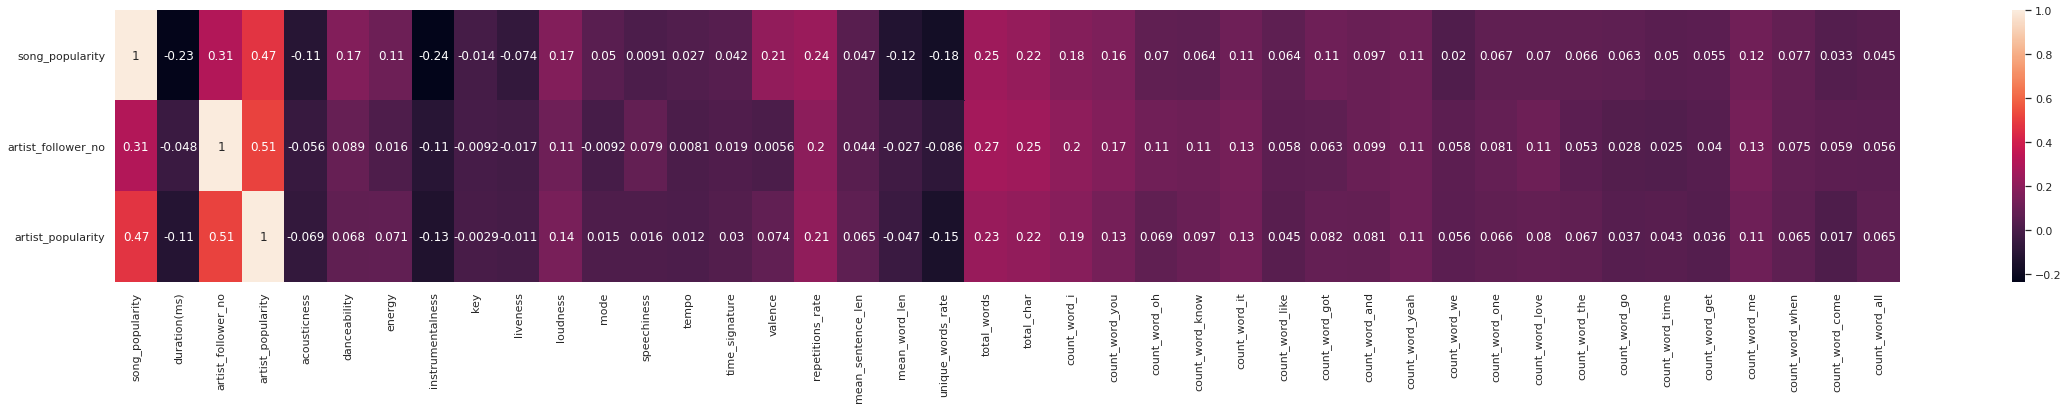

In [235]:
df = pd.read_csv('final_cleaned.csv', encoding='utf-8') 

correlation_matrix = df_numerical.corr()
c = correlation_matrix[abs(correlation_matrix['song_popularity'])>=0.3]

sns.set(rc = {'figure.figsize':(40,5)})
ax = sns.heatmap(data=c, annot=True)

plt.show()

> It appears that song popularity is positively affected by artist_popularity and artist_follower number. Let's have a closer look.

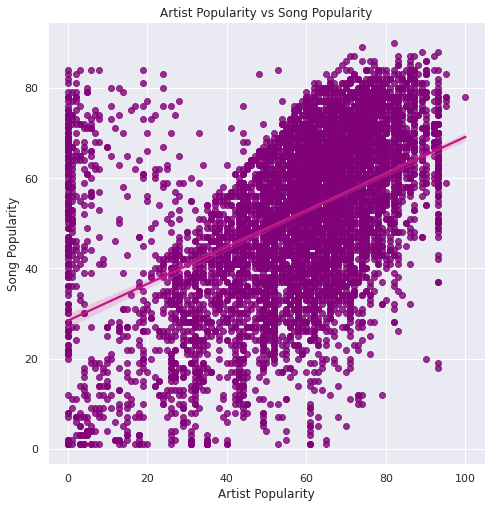

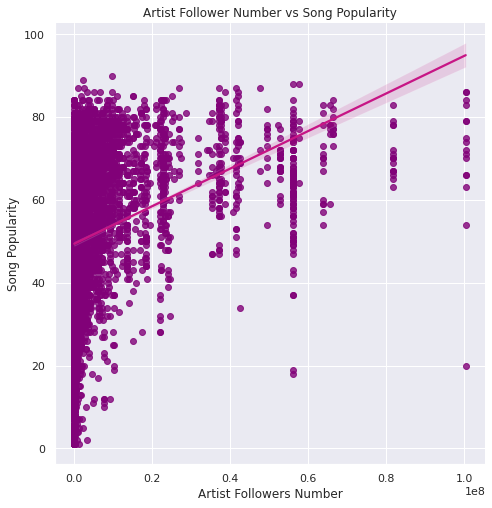

In [239]:
sns.set_palette( "RdPu_r")
sns.lmplot(data=df, x='artist_popularity', y="song_popularity", height=7, line_kws={'color': 'mediumvioletred'})
plt.title('Artist Popularity vs Song Popularity')
plt.xlabel('Artist Popularity')
plt.ylabel('Song Popularity')

sns.lmplot(data=df, x='artist_follower_no', y="song_popularity", height=7, line_kws={'color': 'mediumvioletred'})
plt.title('Artist Follower Number vs Song Popularity')
plt.xlabel('Artist Followers Number')
plt.ylabel('Song Popularity')

plt.show()

According to the diagrams, there's a relatively weak corelation between song popularity and artist popularity, and a weak corelation betwween song popularity and artist follower number.

NB: On the diagram, some artists seem to have low popularity and follower number, but high song popularity. This is because some of the tracks we have are the remixed version, and are release by someone unpopular / a different branch of the singer, and they are unpopular. e.g. shape of you maybe is popular, but the remixed version might be placed under EdSheeraRemix, rather than EdSheeran, which are unlikely to be followed by people. 


### 2. How is song popularity affected by the categorical variables in the dataset?

We use a function to plot distribution of potential catrgorical factors VS song popularity. 

NB: Some of the subgroups for each factors could have a large variation in size, we will print the value counts of each subgroup, and then show a normalised kdeplot. This way we have can taken the affect caused by size difference in subgroups into count when necessary.


In [ ]:
def categorical(df, column):
    print('------------------------------------------------------------------------------------------------')
    print('Size difference in our sub groups:')
    custom_palette = sns.color_palette("gist_rainbow", df[column].nunique())
    df = df.sort_values(by=column)
    print(df[column].value_counts())
    # the commented lines are the distribution with different sample size to visualize the difference in sample size in subgroups 
    # sns.displot(kind='kde', data=df, x="song_popularity", hue=column, linewidth=3, height=5, palette = custom_palette)
    # plt.show()
    sns.set(rc = {'figure.figsize':(10,10)})
    sns.kdeplot(data=df, x="song_popularity", hue=column, linewidth=3, common_norm=False, palette = custom_palette)
    plt.title('Song Popularity vs {}'.format(column))
    plt.show()

------------------------------------------------------------------------------------------------
Size difference in our sub groups:
2010s                4016
2000s                1693
1990s                 604
1980s                 311
1970s                 270
1960s and earlier     205
2020s                 102
Name: release_year, dtype: int64


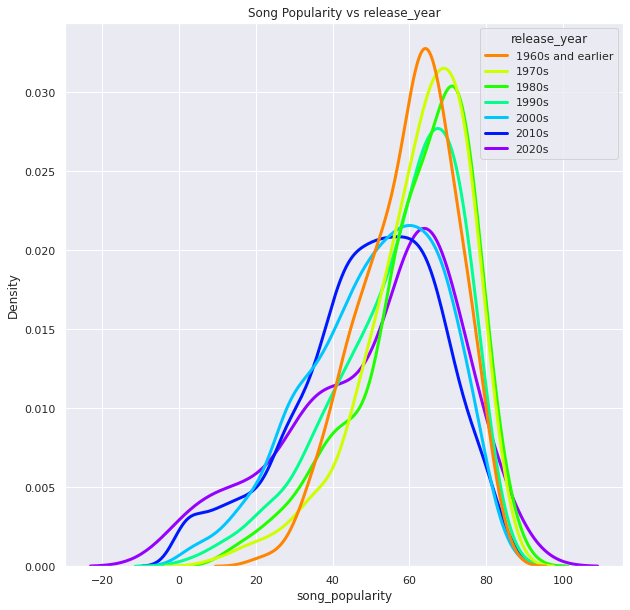

In [ ]:
categorical(df, 'release_year')

According to our diagram, the variance of our data increases as the release year gets more current. For the old songs, only the most popular one stands out. We conclude that there is a relation between song popularity and release year. 

------------------------------------------------------------------------------------------------
Size difference in our sub groups:
False    6682
True      519
Name: explicit, dtype: int64


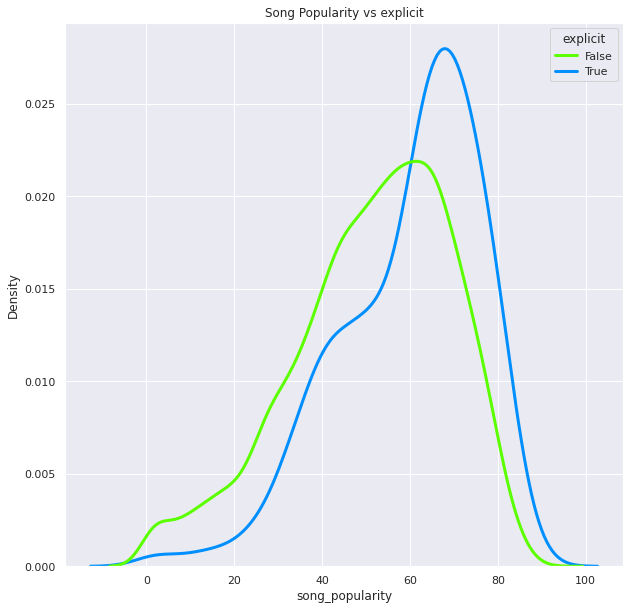

In [ ]:
categorical(df, 'explicit')

There's a huge difference between number of explcit and unexplicit songs, however there shouldn't be a huge effect as contribution would have minor changes when we have above 500 entries.

According to the diagram, song popularity is hugely affected by whether it's explicit or not. Explicit songs tends to be 10 points higher up in song popularity according to Spotify. 

This might be to do with the hiphop songs becoming the trend, and most of hip hop songs are explicit. We will try to proove this assumption later on.

------------------------------------------------------------------------------------------------
Size difference in our sub groups:
metal / rock         2189
electronic           2165
pop                   765
country / folk        379
hip hop / rap         238
christian             225
r&b / soul / jazz     151
Name: artist_genres, dtype: int64


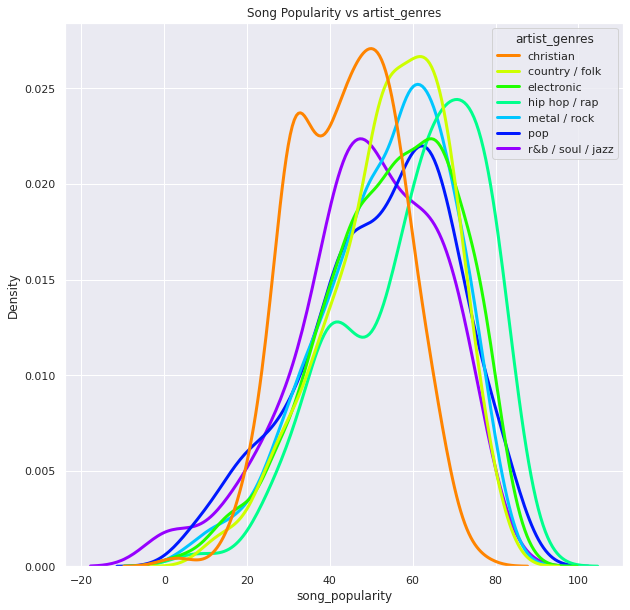

In [ ]:
categorical(df, 'artist_genres')

Even if looking at metal/rock and electronics only, which are comparable as they have around equal sizes, we can still spot a 10-point-difference between these two genres according to Spotify, regarding the rest. The remaining data also agrees that artist genres affect song popularity.

------------------------------------------------------------------------------------------------
Size difference in our sub groups:
1980s                689
1990s and younger    547
1970s                398
1960s                236
1940s                200
1950s                153
Name: birth_decade, dtype: int64


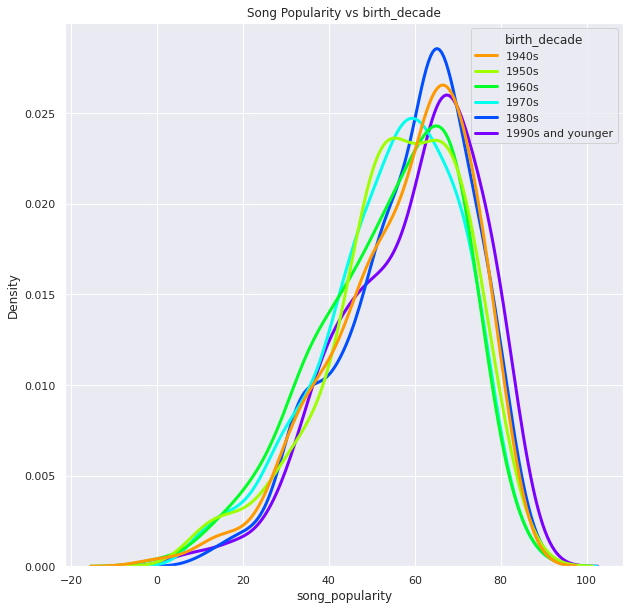

In [ ]:
categorical(df, 'birth_decade')

The size of different subgroups in birth decade is at the same level, so we can look at the diagram straight away. The lines are almost overlapping, and the variation does not necessarily follow the time order. The majority of density of all the subgroups are lying between 60 and 70. We could say there's no relation between song popularity and birth decade.

------------------------------------------------------------------------------------------------
Size difference in our sub groups:
United States     3041
United Kingdom     982
Canada             193
Australia          171
Norway             163
Italy / France     142
Sweden             105
Name: artist_country, dtype: int64


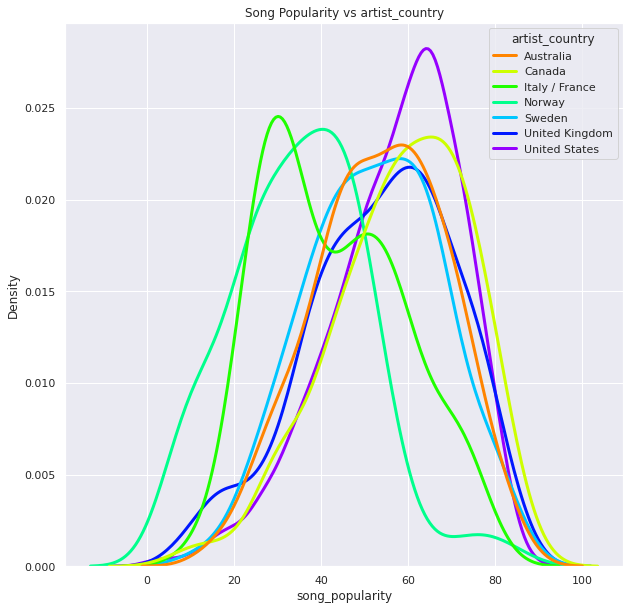

In [ ]:
categorical(df, 'artist_country')

Regarding the size difference in our subgroups, the majority of density from each lies between 30 and 70, which is huge. We can also see that the lines on our diagram is divided into two groups, songs from US, UK, Australia, Canada, Sweden are way more popular than songs from Norway, Italy/France. We can conclude that song popularity is affected by artists' country.

------------------------------------------------------------------------------------------------
Size difference in our sub groups:
male      1083
female     676
Name: gender, dtype: int64


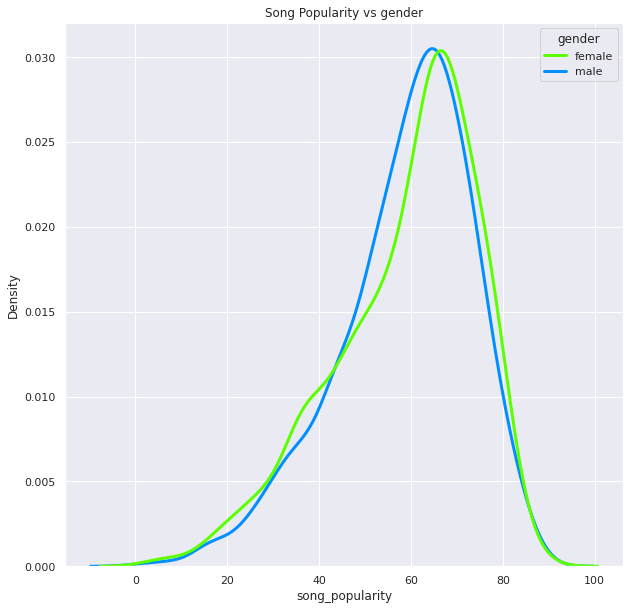

In [ ]:
categorical(df, 'gender')

There's a difference in the sizes of our subgroups, but the effect is negligible, as the distribution shouldn't have a significant change with above 600 entries. We can see the lines representing female and male artists are almost overlapping. We can hence conclude there is no corelation between song popularity and gender.

------------------------------------------------------------------------------------------------
Size difference in our sub groups:
False    3103
True     2361
Name: band, dtype: int64


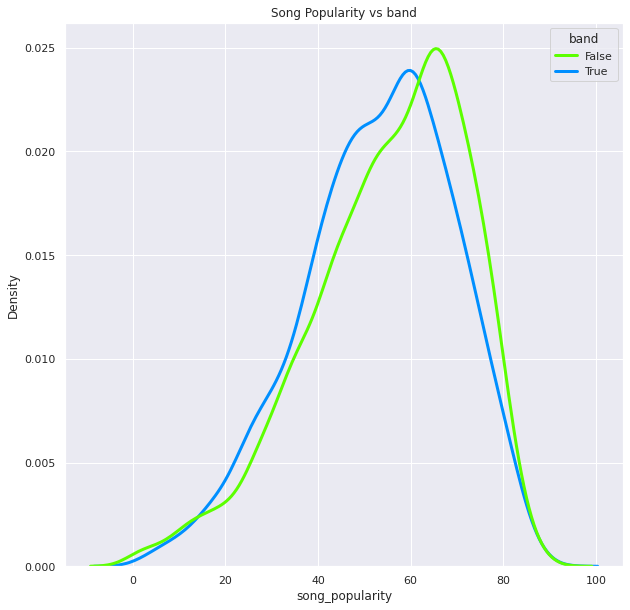

In [ ]:
categorical(df, 'band')

The size of our subgroups are not significantly different considering our huge size. We can see that the majority of single artists are 10-point higher in song popularity than bands according to Spotify. We can conclude that there is a relation between the form of the artists and song popularity.

From the diagrams, we conclude that explicit, artist genres, artist_country have significant relation with song popularity

### Find the most popular artists and take a closer look at the potential factors about themselves that would make them popular

As the strongest numerical factors for song popularity is artist_popularity, we want to figure out what in common do the most popular artist have among our categorical factors.

In [ ]:
df_artist = df[['artist_name', 'artist_popularity', 'artist_genres', 'artist_country']]
df_artist = df_artist.drop_duplicates(subset='artist_name').sort_values('artist_popularity', ascending=False)
df_artist = df_artist[df_artist['artist_popularity']>86]
df_artist

,artist_name,artist_popularity,artist_genres,artist_country
3005,Bad Bunny,100.0,hip hop / rap,Puerto Rico
2802,Drake,95.0,hip hop / rap,Canada
5738,Taylor Swift,93.0,pop,United States
5446,The Weeknd,92.0,pop,Canada
5548,BTS,92.0,pop,NaN
5807,Harry Styles,92.0,pop,United Kingdom
5741,Ed Sheeran,90.0,pop,United Kingdom
2801,Kanye West,90.0,hip hop / rap,United States
5395,Justin Bieber,90.0,pop,Canada
2697,Dua Lipa,89.0,electronic,United Kingdom


Since now we have a small sample size, we need to edit some of the details to mantain accuracy.

In [ ]:
#editing some of the missing details to maintain accuracy
df_artist.loc[5548, 'artist_country']='South Korea'

df_artist

,artist_name,artist_popularity,artist_genres,artist_country
3005,Bad Bunny,100.0,hip hop / rap,Puerto Rico
2802,Drake,95.0,hip hop / rap,Canada
5738,Taylor Swift,93.0,pop,United States
5446,The Weeknd,92.0,pop,Canada
5548,BTS,92.0,pop,South Korea
5807,Harry Styles,92.0,pop,United Kingdom
5741,Ed Sheeran,90.0,pop,United Kingdom
2801,Kanye West,90.0,hip hop / rap,United States
5395,Justin Bieber,90.0,pop,Canada
2697,Dua Lipa,89.0,electronic,United Kingdom


In [ ]:
def artist_factor(column):
  print('------------------------------------------------------------------------------------------------')
  print('Size difference in our sub groups:')
  df = df_artist.sort_values(by=column) 
  print(df[column].value_counts())
  sns.displot(x=column, data=df, height = 10, color='purple')
  plt.show()


------------------------------------------------------------------------------------------------
Size difference in our sub groups:
hip hop / rap    9
pop              6
electronic       4
metal / rock     1
Name: artist_genres, dtype: int64


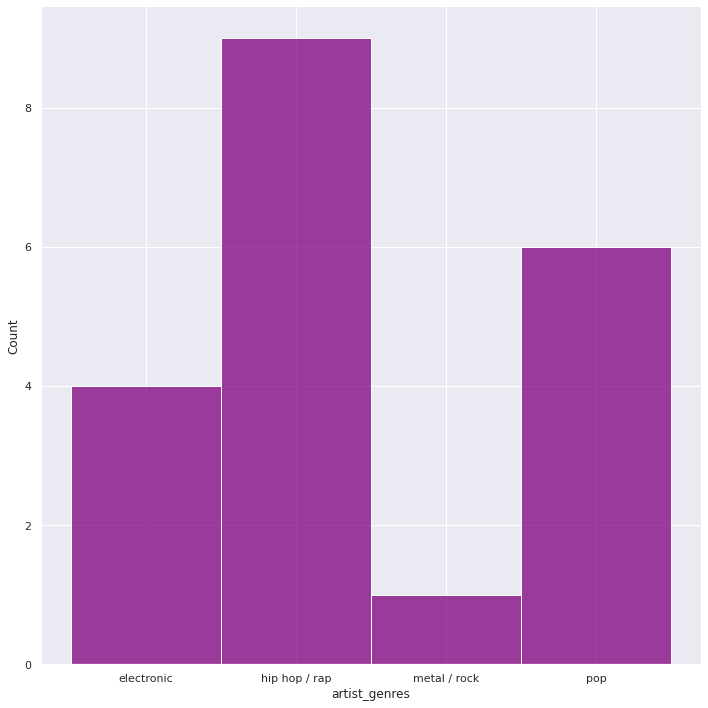

In [ ]:
artist_factor('artist_genres')

We can see the majority of these popular singers are hip hop / rap singers, which is the trending right now, and that confirms our assumption previously (investigation on song popularity vs explicit)

------------------------------------------------------------------------------------------------
Size difference in our sub groups:
United States     10
Canada             3
United Kingdom     3
Puerto Rico        2
Barbados           1
South Korea        1
Name: artist_country, dtype: int64


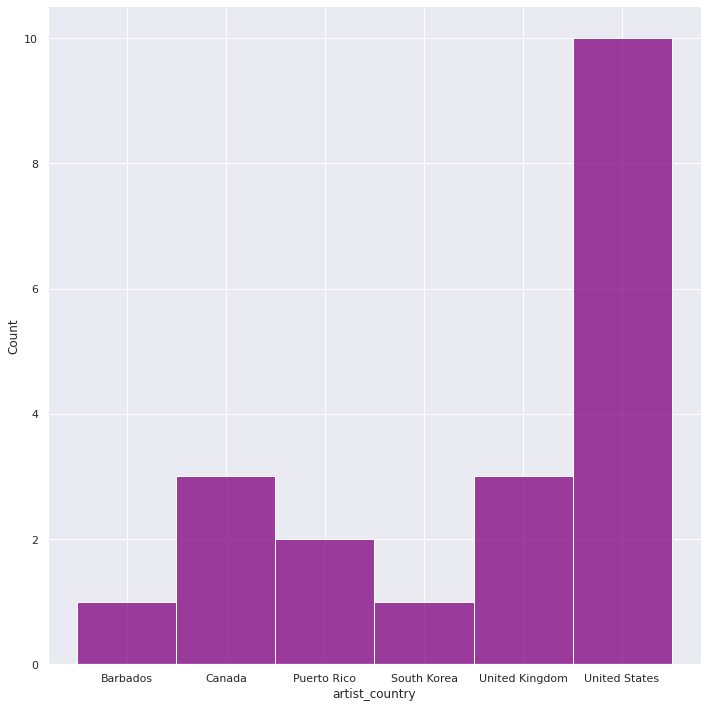

In [ ]:
artist_factor('artist_country')

We can see that the majority of these popular artists are from United States, it's distinctively more than the number of artists from other countries. 

### Song Popularity vs Artists' gender, age, country
For this purpose we calculate new value: age of singer at song's release date.

In [ ]:
df = pd.read_csv('final_cleaned.csv', encoding='utf-8')

# add column with release year of a song
df['release_date'] = df.release_date.apply(lambda x: re.match('\d{4}', x)[0])

# change the type to numeric
df = df.astype({'release_date': 'int64'})

# calculate and save to column age at release
df['age_at_release'] = df['release_date'] - df['birth_year']

# excluding unnatural age values
df_filtered_release_age = df[(df['age_at_release'] > 0) & (df['age_at_release'] < 70)]

Now when we have new variable, we can see how it correlates with song popularity 

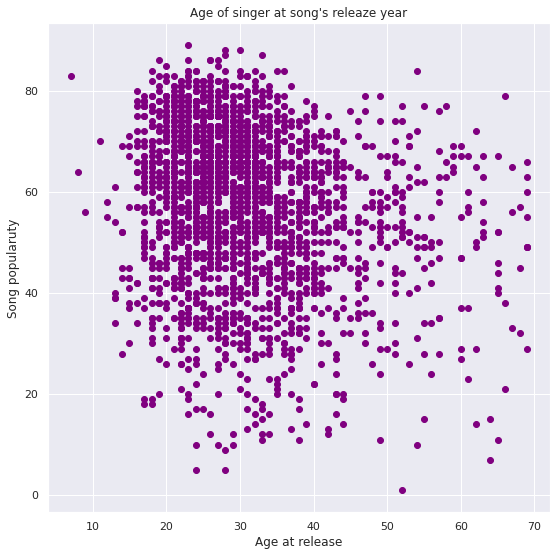

Correlation:  -0.19


In [ ]:
# plot and calculate correlation
plt.figure(figsize = (9,9))
plt.scatter(df_filtered_release_age['age_at_release'], df_filtered_release_age['song_popularity'], marker='o', color='purple')
plt.xlabel('Age at release')
plt.ylabel('Song popularuty')
plt.title("Age of singer at song's releaze year")
plt.show()

release_age_corr = df_filtered_release_age[['song_popularity', 'age_at_release']].corr().song_popularity.age_at_release

print('Correlation: ', round(release_age_corr, 2))

Seems like correlation is weak. Let's see how the variable behaves among the other factors. Maybe there is some difference between genders and countries?
We can use facet grid to biuld multiple plots that involve other variables. 

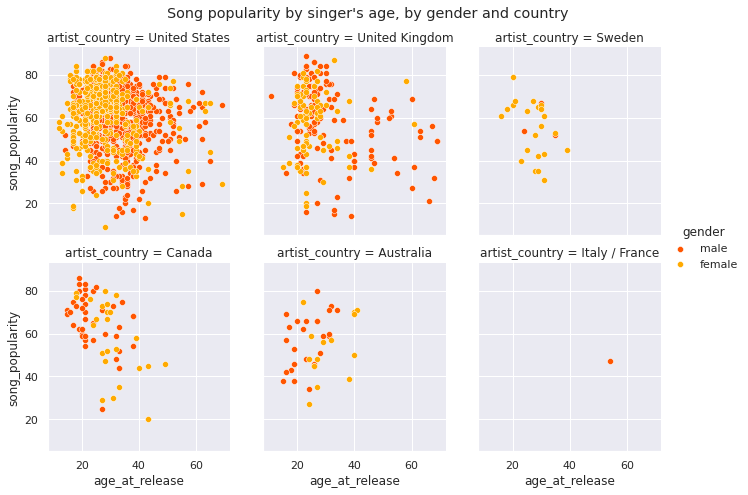

In [ ]:
# making artist related DataFrame
artist_info_df = df[['song_popularity', 'artist_name', 'artist_popularity', 'artist_follower_no', 'artist_genres', 'artist_country', 'gender', 'age_at_release']]
artist_info_df_no_nan = artist_info_df.dropna()

# excluding unnatural age values
artist_info_filtered_age = artist_info_df_no_nan[(artist_info_df_no_nan['age_at_release'] > 0) & (artist_info_df_no_nan['age_at_release'] < 70)]

#plotting the graph for each country
c = sns.FacetGrid(artist_info_filtered_age, col='artist_country', hue="gender",height=3.5, aspect=.9, col_wrap=3, palette = 'autumn')

c.map_dataframe(sns.scatterplot, x='age_at_release', y='song_popularity')

c.fig.subplots_adjust(top=0.9)
c.fig.suptitle("Song popularity by singer's age, by gender and country")
c.add_legend()

For US we have the most of the data. We can see on the graph that songs of woman after their 30 become less popular,
and at age 35 women at most quit singing.
For man, the career path seems to be smoother, and the songs of those, who keeps singing after 40, tend to be at least not that bad.
Let's now see the overall songs popularuty for each gender:

In [ ]:
artist_info_df.groupby('gender')['song_popularity'].mean()

gender
female    58.786982
male      58.732225
Name: song_popularity, dtype: float64

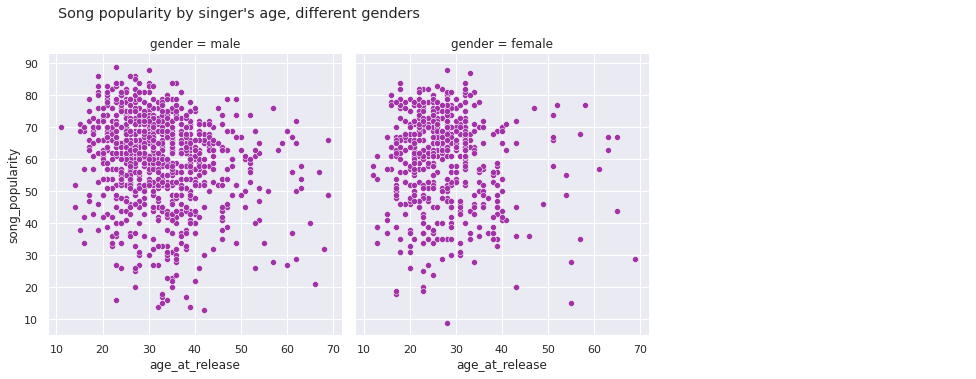

In [240]:
# plotting song popularuty - age at release scatter plot
sns.set_palette(['#a232a8'], n_colors=1)

a = sns.FacetGrid(artist_info_filtered_age, col="gender", height=5, aspect=.9, col_wrap=3)

a.map_dataframe(sns.scatterplot, x='age_at_release', y='song_popularity')

a.add_legend()

a.fig.suptitle(t="Song popularity by singer's age, different genders", y='1.05', x ='0.25')
plt.show()


We see the same picture: after ~32 years women dramatically lose the popularuty of their songs, and after age 40 most of them stop releasing new songs.
Also we can notice, that both women and men sing the most popular songs before they turn 35.
So this is the way that singer's age affects song popularuty.

#**6. Conclusion**
<a id="Conclusion"></a> 
#### Other than release year and explicity, song popularity is generally affected by artists' popularity, follower number, genres, country of orgin, and form (whether it is a band). From our results, most of these factors are about the details of the artists.